<a href="https://colab.research.google.com/github/OlumideF/MScFE_690_Capstone_Student_Group_7139/blob/main/MScFE_690_Capstone_Student_Group_7139_v1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MScFE Capstone Project
## Student Group 7139



1.   Olumide Babatope Falaba - falanaolumide@gmail.com
2.   Nathaniel Azubuike Nwogwu - nathanielnwogwu@yahoo.com
3.   Paul Akinyemi - akinyepa@clarkson.edu

## **Title: Impact of Covid-19 on Local Markets**
## Research Outline

# Library Installations

In [1]:
pip install yfinance pandas numpy statsmodels arch scipy matplotlib scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 982.9/982.9 kB 5.0 MB/s eta 0:00:00


# Import Libraries

In [4]:
import pandas as pd
import numpy as np
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller  # For stationarity test

from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model  # For GARCH modeling
import itertools


# Functions to call

In [16]:
# 1.1 Identify and Collect Data Sources
def fetch_market_data(start_date, end_date, ticker_symbol):
    """
    Fetch historical market data for the given ticker symbol between start_date and end_date.
    """
    data = yf.download(ticker_symbol, start=start_date, end=end_date)
    return data

# 1.2 Data Cleaning and Preprocessing
def clean_data(df):
    """
    Cleans the data by handling missing values and standardizing formats.
    """
    # df.dropna(inplace=True)  # Remove missing values
    # df['Date'] = pd.to_datetime(df['Date'])  # Ensure the date column is in datetime format
    # df.set_index('Date', inplace=True)  # Set the date column as index
    return df

def detect_and_remove_outliers(df, threshold=3):
    """
    Detects and removes outliers using the Z-score method.
    """
    from scipy.stats import zscore
    df_no_outliers = df[(zscore(df) < threshold).all(axis=1)]
    return df_no_outliers

def normalize_data(df, method='zscore'):
    """
    Normalizes data using the specified method: 'zscore' or 'minmax'.
    """
    if method == 'zscore':
        return (df - df.mean()) / df.std()
    elif method == 'minmax':
        return (df - df.min()) / (df.max() - df.min())
    else:
        raise ValueError("Method should be either 'zscore' or 'minmax'")


# 1.3 Exploratory Data Analysis (EDA)
def plot_time_series(df, title='Time Series Data'):
    """
    Plots time series data.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['Close'], label='Close Price')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

def calculate_descriptive_stats(df):
    """
    Calculate and return descriptive statistics of the dataset.
    """
    return df.describe()

def test_stationarity(df, method='ADF'):
    """
    Tests for stationarity of the data using the Augmented Dickey-Fuller test.
    """
    result = adfuller(df['Close'])
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print(f'Critical Values: {key}, {value}')
    return result[1]  # Return p-value


# 2.1 Building ARIMA Models
from statsmodels.tsa.arima.model import ARIMA
import itertools

def fit_arima_model(df, order=(1, 1, 1)):
    """
    Fits an ARIMA model to the time series data.
    """
    model = ARIMA(df['Close'], order=order)
    fitted_model = model.fit()
    print(fitted_model.summary())
    return fitted_model

def optimize_arima_params(df):
    """
    Optimizes ARIMA parameters using AIC.
    """
    p = d = q = range(0, 3)
    pdq_combinations = list(itertools.product(p, d, q))
    best_aic = float('inf')
    best_order = None

    for order in pdq_combinations:
        try:
            model = ARIMA(df['Close'], order=order)
            results = model.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = order
        except:
            continue

    print(f"Best ARIMA order: {best_order} with AIC: {best_aic}")
    return best_order


# 2.2 Residual Analysis and Validation
def analyze_residuals(model):
    """
    Analyzes the residuals of a fitted ARIMA model.
    """
    residuals = model.resid
    plt.figure(figsize=(12, 6))
    plt.plot(residuals, label='Residuals')
    plt.title('Residuals of ARIMA Model')
    plt.show()
    return residuals

def plot_residuals(residuals):
    """
    Plots the residuals to check for patterns or heteroskedasticity.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(residuals, label='Residuals')
    plt.title('Residuals Analysis')
    plt.xlabel('Time')
    plt.ylabel('Residuals')
    plt.legend()
    plt.show()


# 2.3 Applying GARCH Models for Volatility Analysis
def fit_garch_model(df, order=(1, 1)):
    """
    Applies a GARCH model to the residuals of the ARIMA model.
    """
    model = arch_model(df['Close'], vol='Garch', p=order[0], q=order[1])
    garch_model = model.fit(disp='off')
    print(garch_model.summary())
    return garch_model

def validate_garch_model(garch_model):
    """
    Validates the GARCH model by checking for ARCH effects.
    """
    test_arch = garch_model.hedgehog_plot()
    return test_arch


# 3.1 Segmenting Data for Pre-Pandemic, Pandemic, and Post-Pandemic Analysis
def segment_data_by_period(df, start_date, end_date):
    """
    Segments the data into specified periods.
    """
    segmented_data = df[(df.index >= start_date) & (df.index <= end_date)]
    return segmented_data


# 3.2 Conducting Comparative Analysis
from scipy.stats import ttest_ind

def compare_volatility_across_periods(data_dict):
    """
    Compares market volatility across different periods.
    """
    volatilities = {period: data['Close'].pct_change().std() for period, data in data_dict.items()}
    print("Volatility comparison across periods:", volatilities)
    return volatilities

def perform_statistical_tests(data1, data2):
    """
    Performs statistical tests to determine significant differences in volatility.
    """
    t_stat, p_value = ttest_ind(data1['Close'].pct_change().dropna(), data2['Close'].pct_change().dropna())
    print(f'T-test results: t-statistic={t_stat}, p-value={p_value}')
    return p_value


# 4.1 Quantifying Volatility Changes
def calculate_volatility_change(pre_pandemic, pandemic, post_pandemic):
    """
    Calculates changes in volatility between pre-pandemic, pandemic, and post-pandemic periods.
    """
    volatility_pre = pre_pandemic['Close'].pct_change().std()
    volatility_pandemic = pandemic['Close'].pct_change().std()
    volatility_post = post_pandemic['Close'].pct_change().std()
    print(f'Pre-pandemic volatility: {volatility_pre}')
    print(f'Pandemic volatility: {volatility_pandemic}')
    print(f'Post-pandemic volatility: {volatility_post}')
    return volatility_pre, volatility_pandemic, volatility_post

def rolling_volatility_analysis(df, window_size=30):
    """
    Analyzes rolling volatility using a specified window size.
    """
    rolling_volatility = df['Close'].pct_change().rolling(window=window_size).std()
    plt.figure(figsize=(10, 5))
    plt.plot(df.index, rolling_volatility, label='Rolling Volatility')
    plt.title('Rolling Volatility Analysis')
    plt.xlabel('Time')
    plt.ylabel('Volatility')
    plt.legend()
    plt.show()
    return rolling_volatility


# 5.1 Cross-Validation of Models
def cross_validate_arima_model(df, order, k_folds=5):
    """
    Performs cross-validation on ARIMA model using time-series data.

    """
    tscv = TimeSeriesSplit(n_splits=k_folds)
    errors = []

    for train_index, test_index in tscv.split(df):
        train, test = df.iloc[train_index], df.iloc[test_index]

        # Fit the ARIMA model on the training data
        model = ARIMA(train['Close'], order=order)
        fitted_model = model.fit()

        # Forecast on the test set
        predictions = fitted_model.forecast(steps=len(test))
        error = np.mean((predictions - test['Close']) ** 2)  # Mean Squared Error
        errors.append(error)

    mean_error = np.mean(errors)
    print("Cross-validation Mean Squared Error (MSE):", mean_error)
    return mean_error


def sensitivity_analysis_arima(df, base_order=(1, 1, 1), variations=[(-1, 0, 0), (0, -1, 0), (0, 0, -1)]):
    """
    Conducts sensitivity analysis on ARIMA model parameters.

    """
    results = {}
    p, d, q = base_order

    for variation in variations:
        var_order = (p + variation[0], d + variation[1], q + variation[2])
        try:
            model = ARIMA(df['Close'], order=var_order)
            fitted_model = model.fit()
            results[var_order] = {'AIC': fitted_model.aic, 'BIC': fitted_model.bic}
            print(f"Order {var_order} - AIC: {fitted_model.aic}, BIC: {fitted_model.bic}")
        except:
            print(f"Order {var_order} is not a valid model.")
            continue

    return results


# 5.2 Comparing Models' Performance
def compare_model_performance(models, metrics=['AIC', 'BIC', 'MSE']):
    """
    Compares different models' performance based on specified metrics.

    """
    performance = {metric: [] for metric in metrics}

    for model in models:
        # Handle ARIMA models
        if isinstance(model, ARIMA) or isinstance(model, ARIMA.ARIMAResultsWrapper):
            if 'AIC' in metrics:
                performance['AIC'].append(model.aic)
            if 'BIC' in metrics:
                performance['BIC'].append(model.bic)
            if 'MSE' in metrics:
                # Forecast for ARIMA models
                predictions = model.predict(start=0, end=len(model.data.endog)-1)
                mse = np.mean((predictions - model.data.endog) ** 2)
                performance['MSE'].append(mse)

        # Handle GARCH models
        elif hasattr(model, 'forecast'):
            if 'AIC' in metrics:
                performance['AIC'].append(model.aic)
            if 'BIC' in metrics:
                performance['BIC'].append(model.bic)
            if 'MSE' in metrics:
                # Forecast for GARCH models
                forecasts = model.forecast(horizon=1)
                predicted_variance = forecasts.variance.iloc[-1]  # Correct extraction
                actual_returns = model.model.resids[-len(predicted_variance):]
                mse = np.mean((predicted_variance.values - actual_returns ** 2) ** 2)
                performance['MSE'].append(mse)

    print("Model Performance Comparison:")
    for metric in metrics:
        print(f"{metric}: {performance[metric]}")

    return performance


# 6.1 Summarizing Findings
def generate_summary_statistics(df):
    """
    Generates summary statistics of the dataset.
    """
    summary = df.describe()
    print("Summary Statistics:", summary)
    return summary

def generate_report(df, models, insights):
    """
    Generate a comprehensive report summarizing the findings.
    """
    report = {
        'Data Summary': generate_summary_statistics(df),
        'Model Insights': {model_name: model.summary() for model_name, model in models.items()},
        'Key Insights': insights
    }
    return report

# 6.2 Visualizing Results
def visualize_results(data_dict):
    """
    Generates visual aids to communicate key findings.
    """
    for key, data in data_dict.items():
        plt.figure(figsize=(10, 5))
        plt.plot(data.index, data['Close'], label=f'{key} Close Prices')
        plt.title(f'{key} Period Close Prices')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.show()




[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


US Markets Analysis:
Analyzing S&P 500:


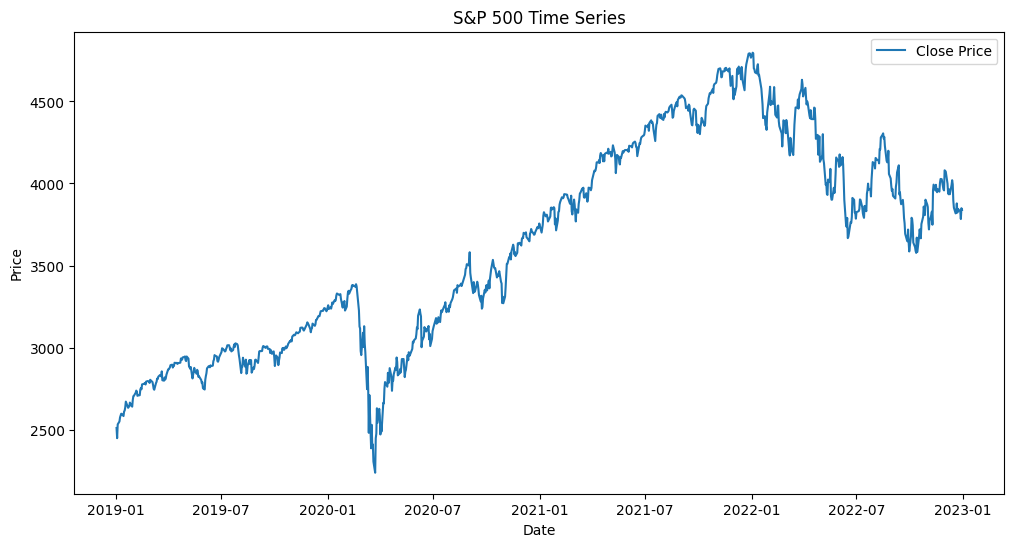

S&P 500 Descriptive Stats:
               Open         High          Low        Close    Adj Close  \
count  1008.000000  1008.000000  1008.000000  1008.000000  1008.000000   
mean   3624.417895  3647.218679  3599.614941  3624.904483  3624.904483   
std     634.838500   637.420319   631.716356   634.328208   634.328208   
min    2290.709961  2300.729980  2191.860107  2237.399902  2237.399902   
25%    3004.890076  3016.355103  2991.074951  3005.232483  3005.232483   
50%    3685.359985  3707.224976  3646.645020  3678.189941  3678.189941   
75%    4182.142578  4202.632446  4158.637573  4180.419922  4180.419922   
max    4804.509766  4818.620117  4780.040039  4796.560059  4796.560059   

             Volume  
count  1.008000e+03  
mean   4.379268e+09  
std    1.109899e+09  
min    1.296530e+09  
25%    3.674172e+09  
50%    4.133645e+09  
75%    4.817915e+09  
max    9.976520e+09  
ADF Statistic: -1.6638130261521755
p-value: 0.44984686012251157
Critical Values: 1%, -3.4369259442540416
Cr

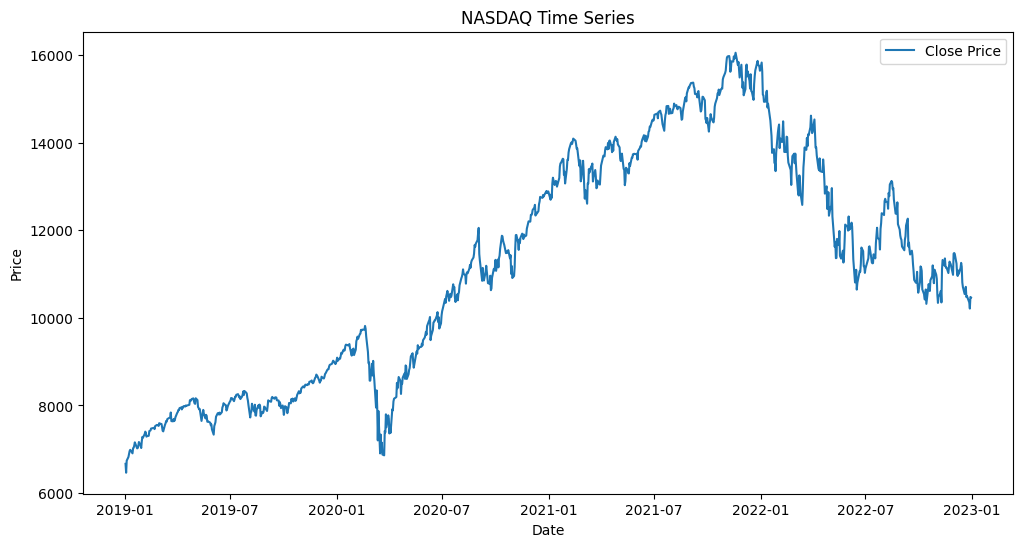

NASDAQ Descriptive Stats:
                Open          High           Low         Close     Adj Close  \
count   1008.000000   1008.000000   1008.000000   1008.000000   1008.000000   
mean   11183.858021  11270.443948  11086.397967  11184.147952  11184.147952   
std     2636.141076   2650.188830   2611.573962   2630.880711   2630.880711   
min     6506.910156   6600.209961   6457.129883   6463.500000   6463.500000   
25%     8470.557617   8536.847168   8448.899902   8518.844971   8518.844971   
50%    11172.680176  11281.794922  11065.435059  11187.955078  11187.955078   
75%    13559.530029  13680.604736  13398.157471  13539.997559  13539.997559   
max    16120.919922  16212.230469  16017.230469  16057.440430  16057.440430   

             Volume  
count  1.008000e+03  
mean   4.061390e+09  
std    1.507580e+09  
min    1.014530e+09  
25%    2.503425e+09  
50%    4.251695e+09  
75%    4.921395e+09  
max    1.162119e+10  
ADF Statistic: -1.6326072037503934
p-value: 0.4661262953693939


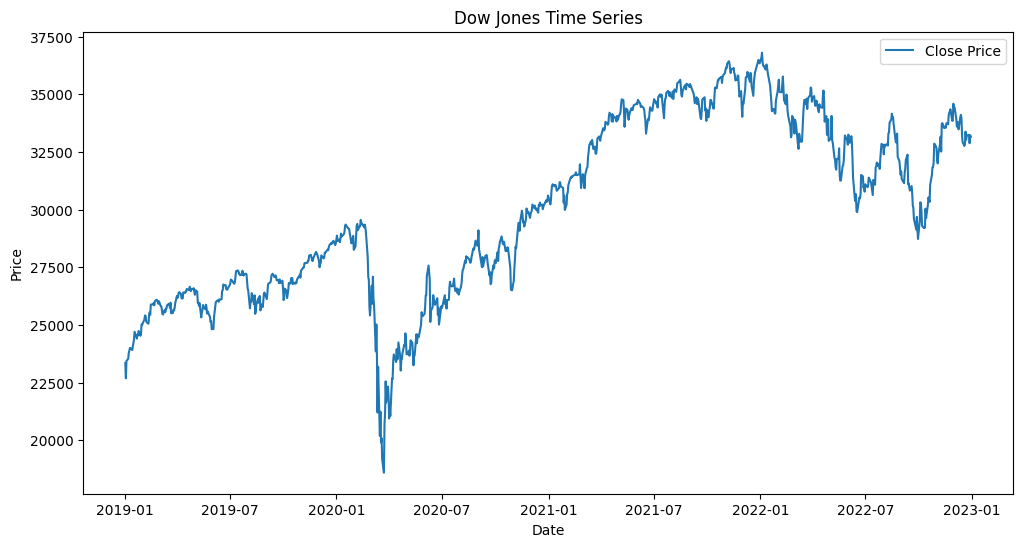

Dow Jones Descriptive Stats:
                Open          High           Low         Close     Adj Close  \
count   1008.000000   1008.000000   1008.000000   1008.000000   1008.000000   
mean   30045.495090  30233.565964  29846.922962  30049.754067  30049.754067   
std     3899.584907   3894.781449   3904.492658   3897.520310   3897.520310   
min    19028.359375  19121.009766  18213.650391  18591.929688  18591.929688   
25%    26665.187988  26804.547363  26535.842773  26658.429688  26658.429688   
50%    30039.640625  30225.644531  29852.725586  30027.115234  30027.115234   
75%    33856.845703  34043.866211  33624.268555  33880.564453  33880.564453   
max    36722.601562  36952.648438  36636.000000  36799.648438  36799.648438   

             Volume  
count  1.008000e+03  
mean   3.502938e+08  
std    1.105337e+08  
min    8.615000e+07  
25%    2.801500e+08  
50%    3.289250e+08  
75%    3.926950e+08  
max    9.159900e+08  
ADF Statistic: -1.7753629118007366
p-value: 0.39276008887450

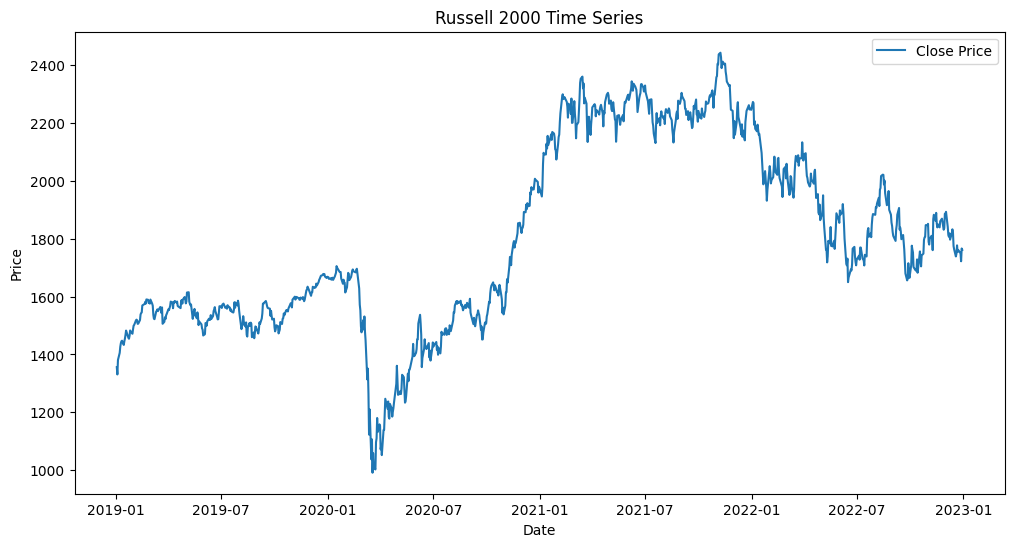

Russell 2000 Descriptive Stats:
               Open         High          Low        Close    Adj Close  \
count  1008.000000  1008.000000  1008.000000  1008.000000  1008.000000   
mean   1798.980119  1814.872222  1781.701816  1799.021579  1799.021579   
std     323.842376   325.597351   322.040286   323.841076   323.841076   
min     988.710022  1017.890015   966.219971   991.159973   991.159973   
25%    1548.809998  1557.512543  1538.487518  1548.782501  1548.782501   
50%    1735.644958  1748.645020  1710.130005  1733.880005  1733.880005   
75%    2125.960022  2140.502441  2092.537537  2123.939941  2123.939941   
max    2442.219971  2458.860107  2438.060059  2442.739990  2442.739990   

             Volume  
count  1.008000e+03  
mean   4.379268e+09  
std    1.109899e+09  
min    1.296530e+09  
25%    3.674172e+09  
50%    4.133645e+09  
75%    4.817915e+09  
max    9.976520e+09  
ADF Statistic: -1.622883190633829
p-value: 0.47121807742180655
Critical Values: 1%, -3.4369193380671
C

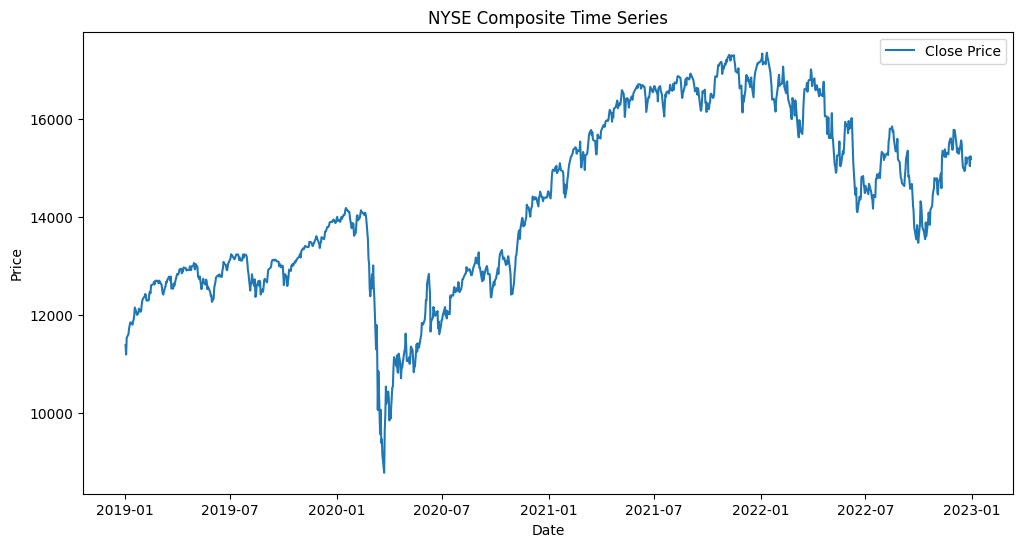

NYSE Composite Descriptive Stats:
                Open          High           Low         Close     Adj Close  \
count   1008.000000   1008.000000   1008.000000   1008.000000   1008.000000   
mean   14298.504487  14384.024324  14204.189386  14298.724716  14298.724716   
std     1818.452312   1821.635491   1818.281998   1820.119314   1820.119314   
min     9014.580078   9053.490234   8664.940430   8777.379883   8777.379883   
25%    12820.882568  12886.202393  12773.230225  12833.570312  12833.570312   
50%    14169.689941  14268.879883  14103.224609  14185.720215  14185.720215   
75%    16022.340088  16120.575195  15889.459717  16022.340088  16022.340088   
max    17353.759766  17442.539062  17285.550781  17353.759766  17353.759766   

             Volume  
count  1.008000e+03  
mean   4.379268e+09  
std    1.109899e+09  
min    1.296530e+09  
25%    3.674172e+09  
50%    4.133645e+09  
75%    4.817915e+09  
max    9.976520e+09  
ADF Statistic: -1.8729929978043844
p-value: 0.344870739

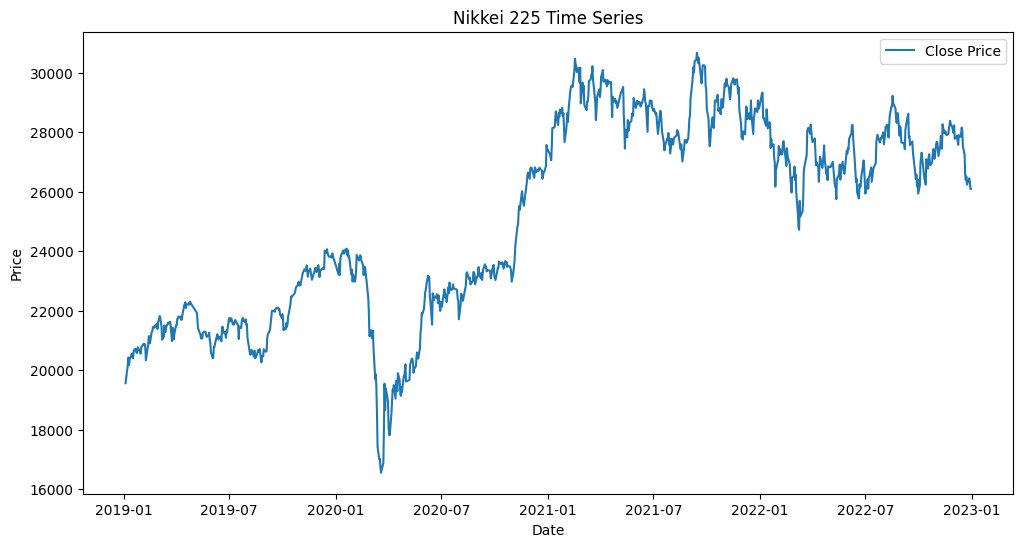

Nikkei 225 Descriptive Stats:
                Open          High           Low         Close     Adj Close  \
count    972.000000    972.000000    972.000000    972.000000    972.000000   
mean   25144.077520  25274.935404  24998.165981  25143.022650  25143.022650   
std     3305.945560   3314.601886   3296.913442   3301.795298   3301.795298   
min    16570.570312  17049.029297  16358.190430  16552.830078  16552.830078   
25%    22128.797852  22251.464844  21982.077637  22087.361816  22087.361816   
50%    26284.674805  26458.759766  26121.685547  26271.584961  26271.584961   
75%    28031.257812  28177.424316  27865.048340  28028.618164  28028.618164   
max    30606.150391  30795.779297  30504.810547  30670.099609  30670.099609   

             Volume  
count  9.720000e+02  
mean   7.123405e+07  
std    2.153491e+07  
min    0.000000e+00  
25%    5.797500e+07  
50%    6.780000e+07  
75%    7.940000e+07  
max    2.334000e+08  
ADF Statistic: -1.8997641311397522
p-value: 0.3321720790129

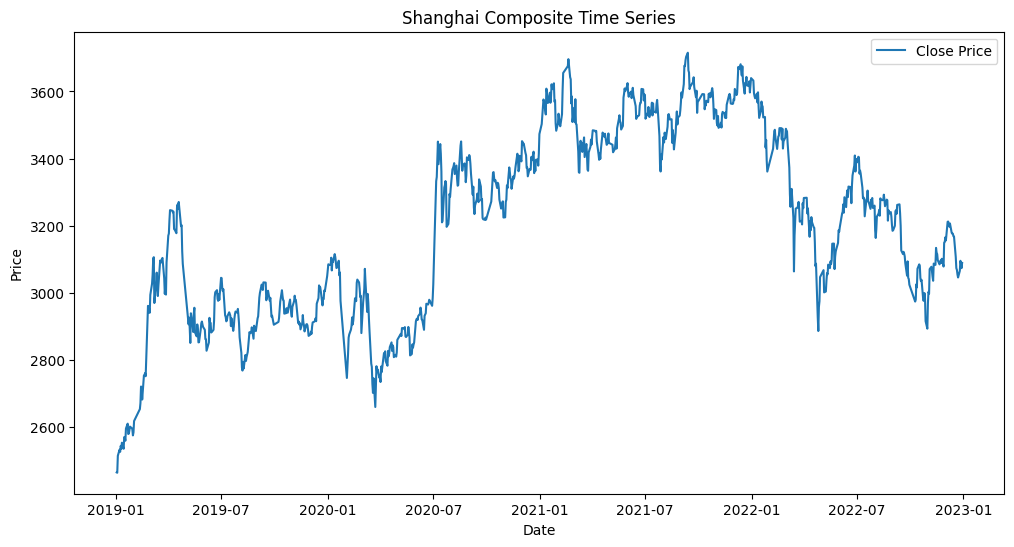

Shanghai Composite Descriptive Stats:
               Open         High          Low        Close    Adj Close  \
count   970.000000   970.000000   970.000000   970.000000   970.000000   
mean   3200.809659  3221.872722  3180.172508  3203.250807  3203.250807   
std     279.613178   279.417942   277.370526   278.658438   278.658438   
min    2446.019043  2488.479004  2440.906982  2464.363037  2464.363037   
25%    2964.737488  2984.024597  2939.145813  2967.886292  2967.886292   
50%    3224.828491  3251.223022  3202.636963  3224.445923  3224.445923   
75%    3445.812500  3466.209839  3423.130066  3450.290771  3450.290771   
max    3721.086914  3731.687012  3692.820068  3715.370117  3715.370117   

              Volume  
count     970.000000  
mean   295935.051546  
std     99619.600984  
min       100.000000  
25%    220875.000000  
50%    297150.000000  
75%    357850.000000  
max    667300.000000  
ADF Statistic: -2.855966915239575
p-value: 0.050713285497872504
Critical Values: 1%, -3

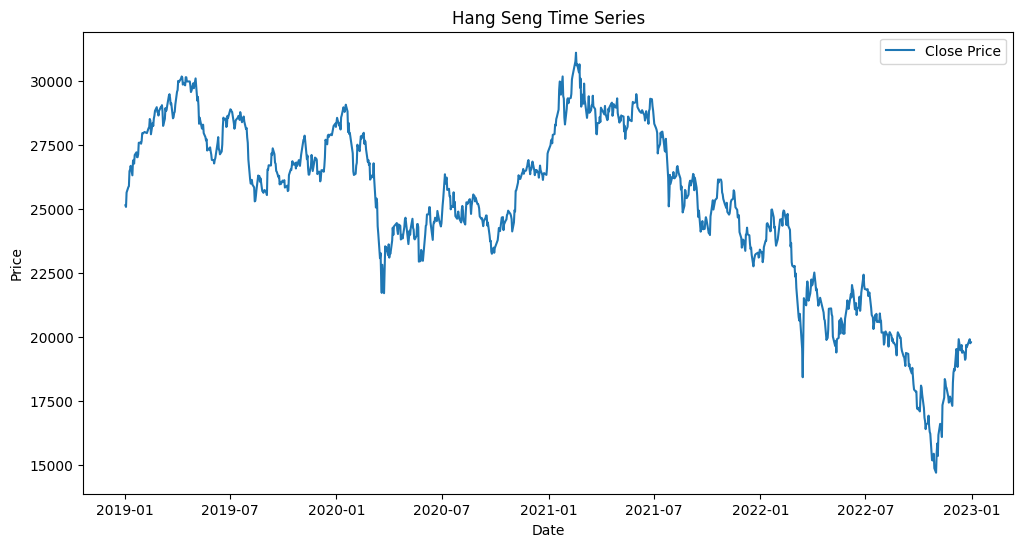

Hang Seng Descriptive Stats:
                Open          High           Low         Close     Adj Close  \
count    987.000000    987.000000    987.000000    987.000000    987.000000   
mean   25095.167592  25259.084964  24887.682026  25081.839645  25081.839645   
std     3404.192107   3384.394850   3413.625667   3399.882230   3399.882230   
min    14830.690430  15113.150391  14597.309570  14687.019531  14687.019531   
25%    23519.520508  23604.929688  23189.879883  23409.214844  23409.214844   
50%    25736.880859  25847.109375  25520.669922  25707.929688  25707.929688   
75%    27817.975586  27956.584961  27695.594727  27845.470703  27845.470703   
max    31183.359375  31183.359375  30570.550781  31084.939453  31084.939453   

             Volume  
count  9.870000e+02  
mean   2.120518e+09  
std    8.050547e+08  
min    0.000000e+00  
25%    1.633448e+09  
50%    1.941502e+09  
75%    2.418627e+09  
max    6.012760e+09  
ADF Statistic: -1.2246136665869871
p-value: 0.66291893805134

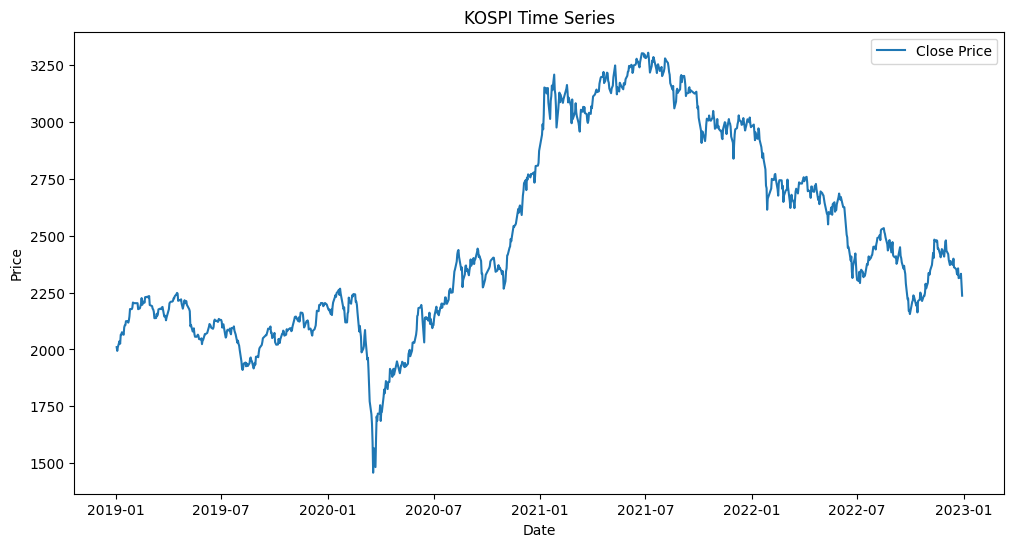

KOSPI Descriptive Stats:
               Open         High          Low        Close    Adj Close  \
count   986.000000   986.000000   986.000000   986.000000   986.000000   
mean   2491.245019  2505.511379  2473.949038  2489.982858  2489.982858   
std     430.845579   432.352190   429.011714   430.446077   430.446077   
min    1474.449951  1516.750000  1439.430054  1457.640015  1457.640015   
25%    2141.460022  2153.652527  2125.494995  2141.117554  2141.117554   
50%    2373.609985  2387.719971  2355.854980  2371.025024  2371.025024   
75%    2935.392456  2952.185059  2910.629944  2929.472412  2929.472412   
max    3305.459961  3316.080078  3295.439941  3305.209961  3305.209961   

             Volume  
count  9.860000e+02  
mean   7.505077e+05  
std    3.747429e+05  
min    2.575000e+05  
25%    4.764750e+05  
50%    6.469500e+05  
75%    9.171250e+05  
max    3.455500e+06  
ADF Statistic: -1.3360380927190252
p-value: 0.6125278802129854
Critical Values: 1%, -3.4370198458812156
Criti

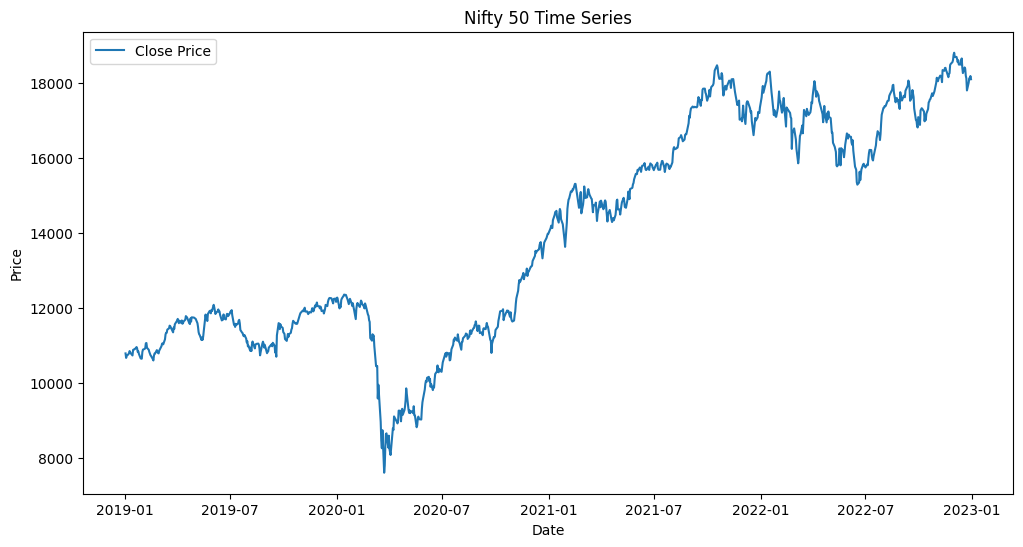

Nifty 50 Descriptive Stats:
                Open          High           Low         Close     Adj Close  \
count    987.000000    987.000000    987.000000    987.000000    987.000000   
mean   13988.102636  14063.330449  13885.833675  13977.500560  13977.500560   
std     2911.359708   2914.440314   2906.921248   2913.203744   2913.203744   
min     7735.149902   8036.950195   7511.100098   7610.250000   7610.250000   
25%    11468.074707  11528.025391  11392.449707  11447.149902  11447.149902   
50%    13980.900391  14049.849609  13929.299805  13981.950195  13981.950195   
75%    16997.575195  17113.500000  16837.325195  16979.274414  16979.274414   
max    18871.949219  18887.599609  18778.199219  18812.500000  18812.500000   

             Volume  
count  9.870000e+02  
mean   4.589584e+05  
std    2.240073e+05  
min    0.000000e+00  
25%    2.843500e+05  
50%    4.142000e+05  
75%    6.027500e+05  
max    1.811000e+06  
ADF Statistic: -0.6863247727727216
p-value: 0.850260002915123

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Best ARIMA order: (2, 1, 2) with AIC: 10601.611385316657


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1008
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -5295.806
Date:                Wed, 25 Sep 2024   AIC                          10601.611
Time:                        01:31:58   BIC                          10626.185
Sample:                             0   HQIC                         10610.948
                               - 1008                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7552      0.030    -58.036      0.000      -1.815      -1.696
ar.L2         -0.8829      0.028    -31.384      0.000      -0.938      -0.828
ma.L1          1.6622      0.040     42.054      0.0

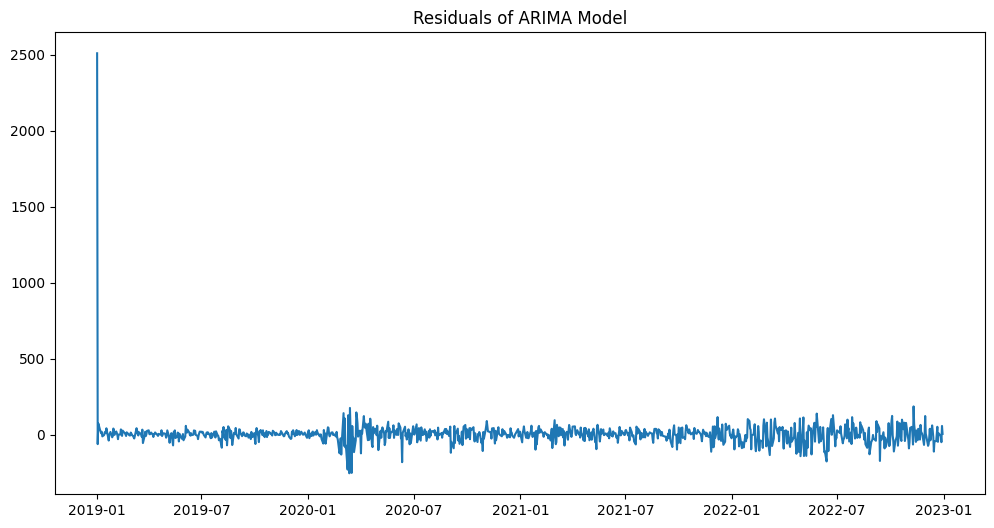

Fitting ARIMA model to NASDAQ:


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Best ARIMA order: (2, 1, 2) with AIC: 13292.677491741326


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1008
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -6641.339
Date:                Wed, 25 Sep 2024   AIC                          13292.677
Time:                        01:32:15   BIC                          13317.251
Sample:                             0   HQIC                         13302.014
                               - 1008                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7796      0.033    -54.428      0.000      -1.844      -1.715
ar.L2         -0.9040      0.032    -28.665      0.000      -0.966      -0.842
ma.L1          1.7042      0.043     39.927      0.0

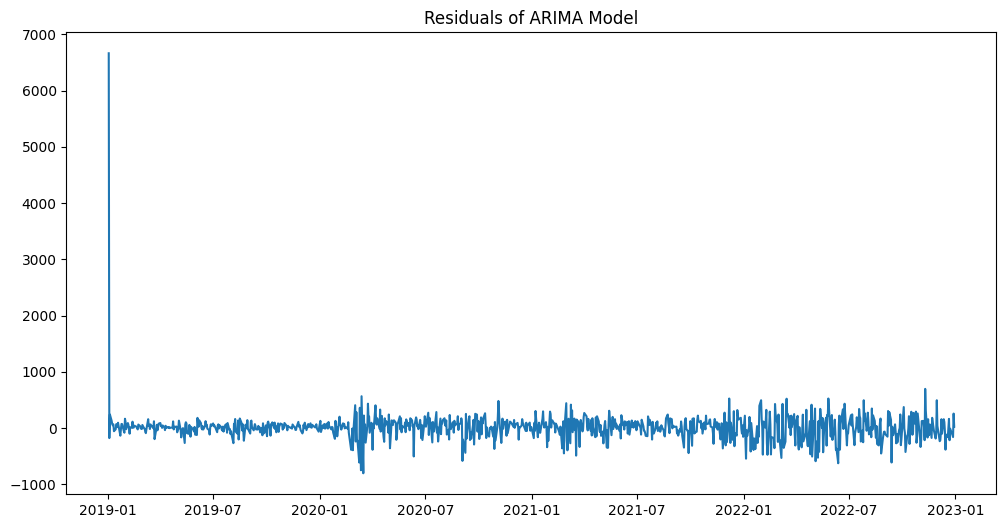

Fitting ARIMA model to Dow Jones:


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Best ARIMA order: (2, 1, 2) with AIC: 14743.840323780576


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1008
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -7366.920
Date:                Wed, 25 Sep 2024   AIC                          14743.840
Time:                        01:32:31   BIC                          14768.414
Sample:                             0   HQIC                         14753.177
                               - 1008                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7312      0.026    -65.836      0.000      -1.783      -1.680
ar.L2         -0.8751      0.024    -36.433      0.000      -0.922      -0.828
ma.L1          1.6143      0.035     46.752      0.0

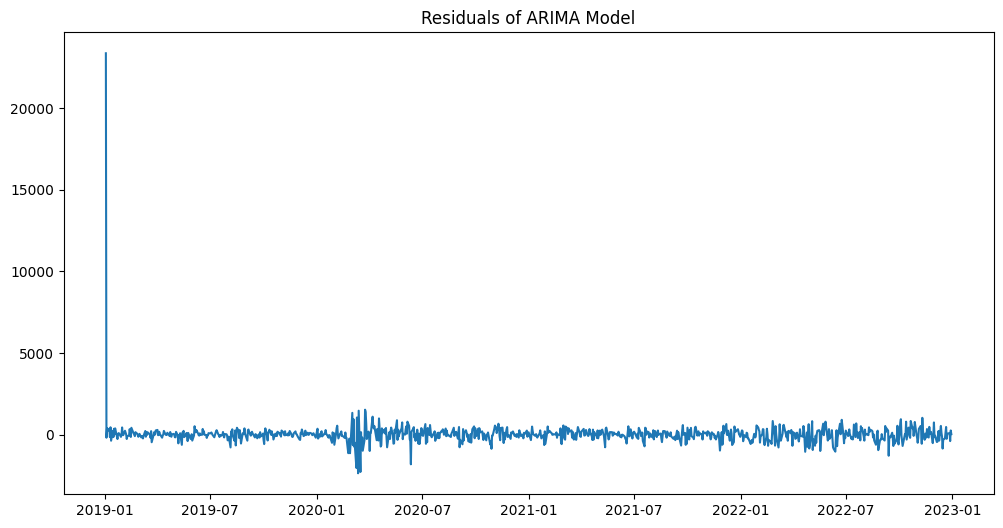

Fitting ARIMA model to Russell 2000:


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Best ARIMA order: (2, 1, 2) with AIC: 9657.259306392567


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1008
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -4823.630
Date:                Wed, 25 Sep 2024   AIC                           9657.259
Time:                        01:32:47   BIC                           9681.833
Sample:                             0   HQIC                          9666.596
                               - 1008                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7111      0.052    -32.996      0.000      -1.813      -1.609
ar.L2         -0.8546      0.050    -17.053      0.000      -0.953      -0.756
ma.L1          1.6284      0.064     25.512      0.0

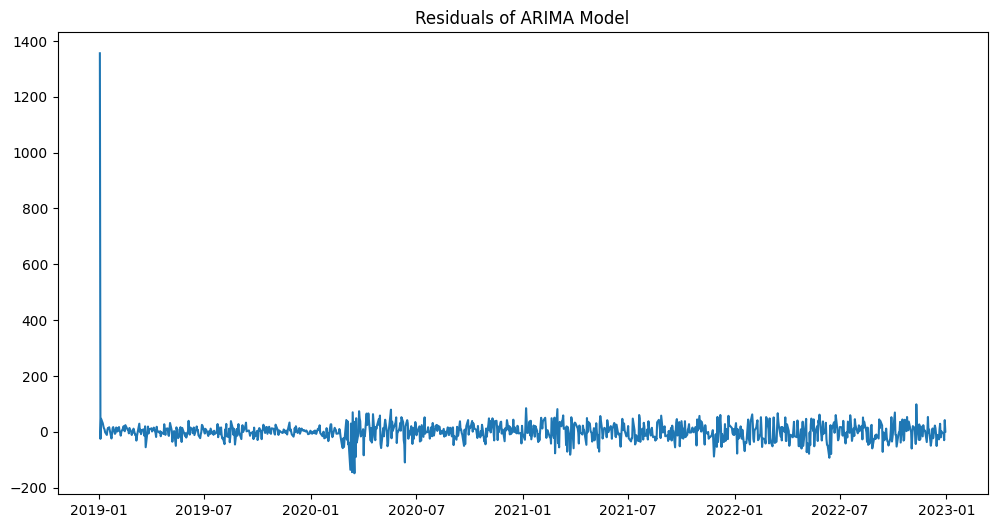

Fitting ARIMA model to NYSE Composite:


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Best ARIMA order: (2, 1, 2) with AIC: 13224.62823378831


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1008
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -6607.314
Date:                Wed, 25 Sep 2024   AIC                          13224.628
Time:                        01:33:02   BIC                          13249.202
Sample:                             0   HQIC                         13233.965
                               - 1008                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7332      0.032    -54.745      0.000      -1.795      -1.671
ar.L2         -0.8680      0.029    -30.001      0.000      -0.925      -0.811
ma.L1          1.6418      0.040     40.603      0.0

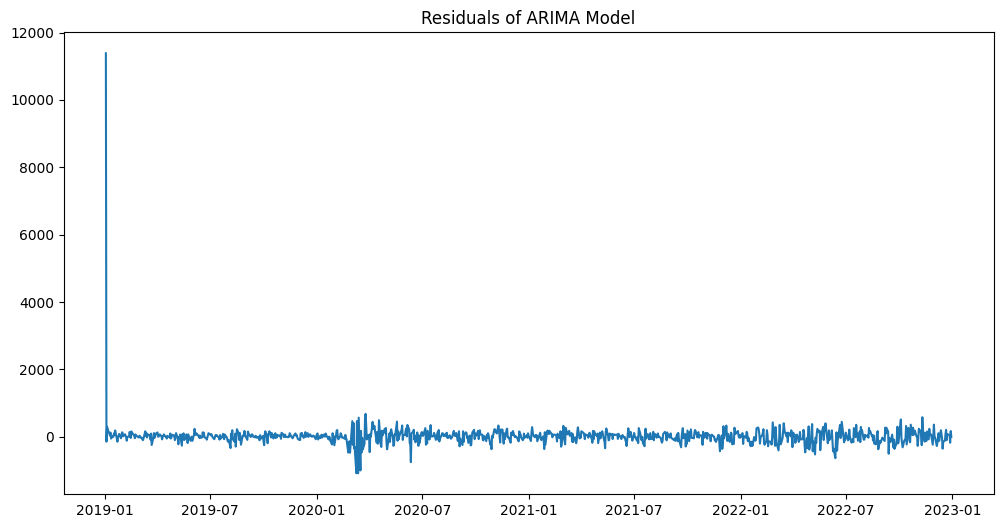

Fitting ARIMA Models to Asian Markets:
Fitting ARIMA model to Nikkei 225:


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Best ARIMA order: (2, 1, 1) with AIC: 13890.851100961343


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  972
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -6941.426
Date:                Wed, 25 Sep 2024   AIC                          13890.851
Time:                        01:33:15   BIC                          13910.364
Sample:                             0   HQIC                         13898.278
                                - 972                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6528      0.185     -3.519      0.000      -1.016      -0.289
ar.L2          0.0697      0.029      2.388      0.017       0.012       0.127
ma.L1          0.6558      0.187      3.500      0.0

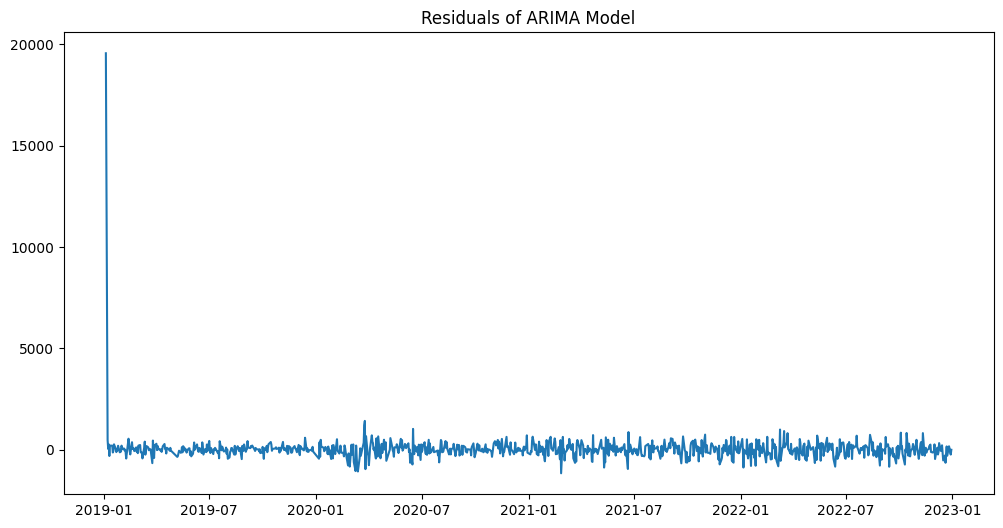

Fitting ARIMA model to Shanghai Composite:


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Best ARIMA order: (0, 2, 1) with AIC: 9669.224795665734


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  970
Model:                 ARIMA(0, 2, 1)   Log Likelihood               -4832.612
Date:                Wed, 25 Sep 2024   AIC                           9669.225
Time:                        01:33:28   BIC                           9678.975
Sample:                             0   HQIC                          9672.936
                                - 970                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9981      0.005   -197.385      0.000      -1.008      -0.988
sigma2      1263.2417     31.696     39.855      0.000    1201.119    1325.365
Ljung-Box (L1) (Q):                   0.46   Jarque-

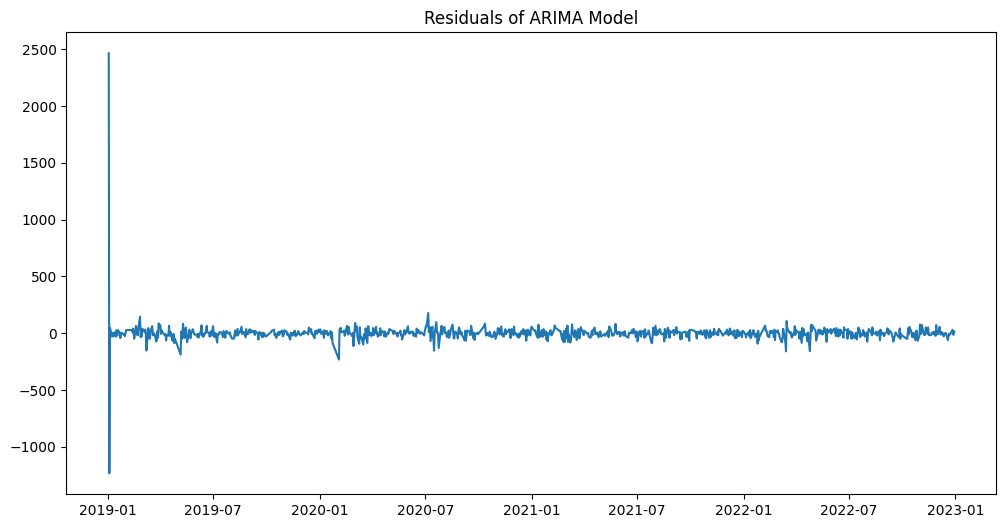

Fitting ARIMA model to Hang Seng:


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Best ARIMA order: (0, 1, 0) with AIC: 14335.800350755802
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  987
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -7166.900
Date:                Wed, 25 Sep 2024   AIC                          14335.800
Time:                        01:33:42   BIC                          14340.694
Sample:                             0   HQIC                         14337.662
                                - 987                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.204e+05   4022.593     29.927      0.000    1.12e+05    1.28e+05
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):            

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


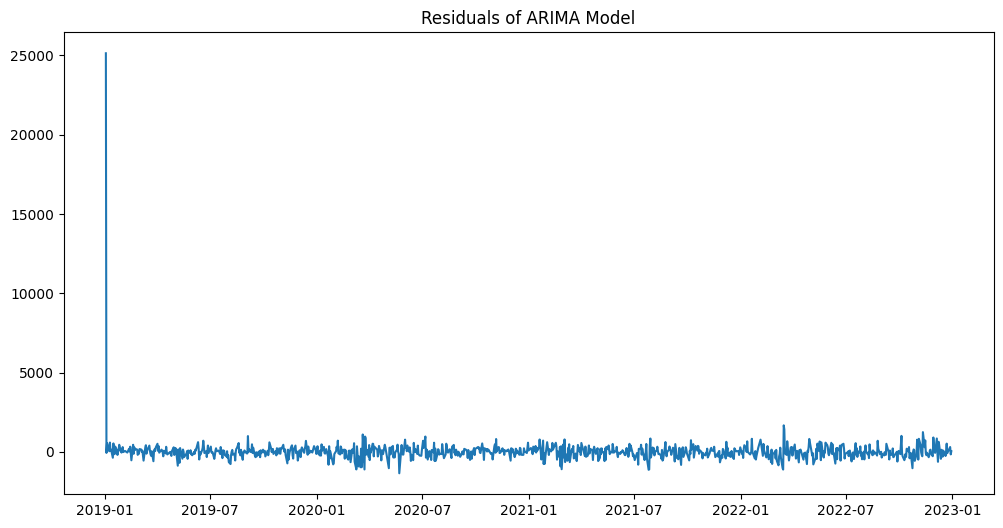

Fitting ARIMA model to KOSPI:


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Best ARIMA order: (2, 2, 1) with AIC: 9425.092145557064


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  986
Model:                 ARIMA(2, 2, 1)   Log Likelihood               -4708.546
Date:                Wed, 25 Sep 2024   AIC                           9425.092
Time:                        01:33:56   BIC                           9444.659
Sample:                             0   HQIC                          9432.535
                                - 986                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0103      0.020      0.511      0.609      -0.029       0.050
ar.L2          0.0648      0.023      2.858      0.004       0.020       0.109
ma.L1         -0.9948      0.003   -321.078      0.0

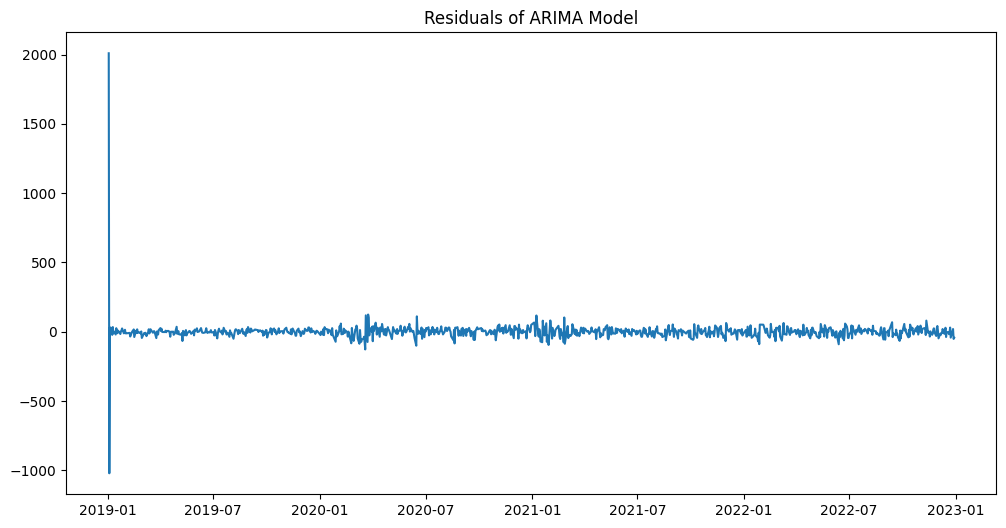

Fitting ARIMA model to Nifty 50:


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Best ARIMA order: (0, 2, 1) with AIC: 12824.57821750243
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  987
Model:                 ARIMA(0, 2, 1)   Log Likelihood               -6410.289
Date:                Wed, 25 Sep 2024   AIC                          12824.578
Time:                        01:34:09   BIC                          12834.364
Sample:                             0   HQIC                         12828.300
                                - 987                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9990      0.010   -100.071      0.000      -1.019      -0.979
sigma2      2.608e+04    637.012     40.935      0.000    2.48e+04    2.73e

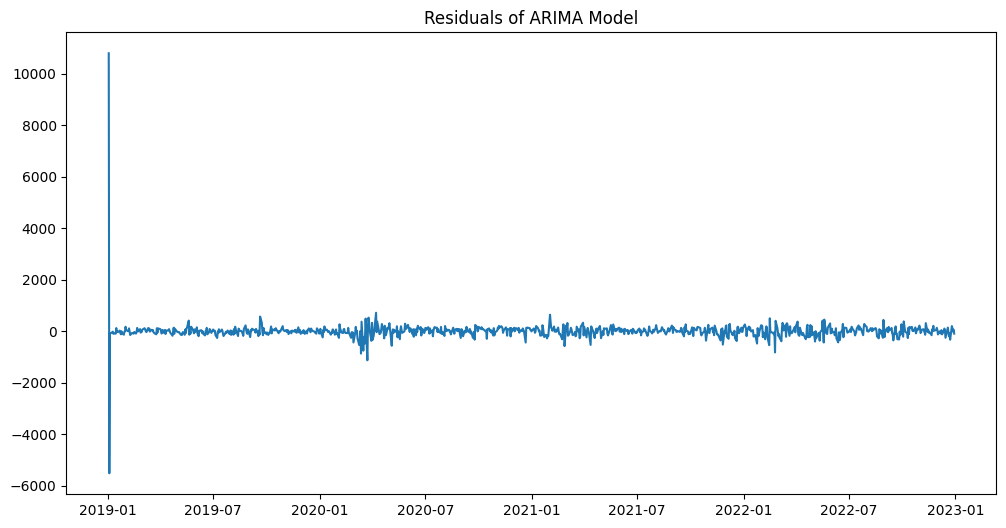

Comparing Volatility Between US and Asian Markets:
US Market Volatilities: {'S&P 500': 0.014436224554981983, 'NASDAQ': 0.01684261623026066, 'Dow Jones': 0.014278123990543906, 'Russell 2000': 0.018201866691919234, 'NYSE Composite': 0.013826949683012183}
Asian Market Volatilities: {'Nikkei 225': 0.01269233978957565, 'Shanghai Composite': 0.011260458657336112, 'Hang Seng': 0.014983771374475048, 'KOSPI': 0.01251962501860636, 'Nifty 50': 0.013096890795804195}


In [17]:
# 1.1 Define US and Asian Indexes Separately
us_indexes = {
    'S&P 500': '^GSPC',
    'NASDAQ': '^IXIC',
    'Dow Jones': '^DJI',
    'Russell 2000': '^RUT',
    'NYSE Composite': '^NYA'
}

asian_indexes = {
    'Nikkei 225': '^N225',
    'Shanghai Composite': '000001.SS',
    'Hang Seng': '^HSI',
    'KOSPI': '^KS11',
    'Nifty 50': '^NSEI'
}

# 1.2 Fetching Data Separately
def fetch_all_market_data(index_dict, start_date, end_date):
    """
    Fetches historical data for all the indexes in the dictionary.
    """
    market_data = {}
    for name, ticker in index_dict.items():
        data = fetch_market_data(start_date, end_date, ticker)
        cleaned_data = clean_data(data)
        market_data[name] = cleaned_data
    return market_data

# Fetch US Market Data
us_market_data = fetch_all_market_data(us_indexes, '2019-01-01', '2023-01-01')

# Fetch Asian Market Data
asian_market_data = fetch_all_market_data(asian_indexes, '2019-01-01', '2023-01-01')


# 2.1 Analysis - US and Asian Data can be processed separately

# Apply exploratory data analysis for US Markets
def analyze_us_markets(us_market_data):
    """
    Analyzes US market data including time series plots and statistical tests.
    """
    for name, df in us_market_data.items():
        print(f"Analyzing {name}:")
        plot_time_series(df, title=f'{name} Time Series')
        descriptive_stats = calculate_descriptive_stats(df)
        print(f'{name} Descriptive Stats:\n', descriptive_stats)
        adf_p_value = test_stationarity(df)
        print(f'{name} Stationarity Test p-value:', adf_p_value)

# Apply exploratory data analysis for Asian Markets
def analyze_asian_markets(asian_market_data):
    """
    Analyzes Asian market data including time series plots and statistical tests.
    """
    for name, df in asian_market_data.items():
        print(f"Analyzing {name}:")
        plot_time_series(df, title=f'{name} Time Series')
        descriptive_stats = calculate_descriptive_stats(df)
        print(f'{name} Descriptive Stats:\n', descriptive_stats)
        adf_p_value = test_stationarity(df)
        print(f'{name} Stationarity Test p-value:', adf_p_value)


# 3.1 ARIMA Modeling
def fit_arima_to_us_markets(us_market_data):
    """
    Fits ARIMA models to US markets.
    """
    for name, df in us_market_data.items():
        print(f"Fitting ARIMA model to {name}:")
        best_order = optimize_arima_params(df)
        fitted_model = fit_arima_model(df, order=best_order)
        analyze_residuals(fitted_model)

def fit_arima_to_asian_markets(asian_market_data):
    """
    Fits ARIMA models to Asian markets.
    """
    for name, df in asian_market_data.items():
        print(f"Fitting ARIMA model to {name}:")
        best_order = optimize_arima_params(df)
        fitted_model = fit_arima_model(df, order=best_order)
        analyze_residuals(fitted_model)


# 4.1 Comparative Volatility Analysis
def compare_volatility_between_us_and_asian(us_market_data, asian_market_data):
    """
    Compares the volatility between US and Asian markets.
    """
    us_volatility = {name: df['Close'].pct_change().std() for name, df in us_market_data.items()}
    asian_volatility = {name: df['Close'].pct_change().std() for name, df in asian_market_data.items()}

    print("US Market Volatilities:", us_volatility)
    print("Asian Market Volatilities:", asian_volatility)

    return us_volatility, asian_volatility


# 5.1 Execute Analysis
if __name__ == "__main__":
    # Perform US market analysis
    print("US Markets Analysis:")
    analyze_us_markets(us_market_data)

    # Perform Asian market analysis
    print("Asian Markets Analysis:")
    analyze_asian_markets(asian_market_data)

    # Fit ARIMA models to US and Asian markets
    print("Fitting ARIMA Models to US Markets:")
    fit_arima_to_us_markets(us_market_data)

    print("Fitting ARIMA Models to Asian Markets:")
    fit_arima_to_asian_markets(asian_market_data)

    # Compare volatility between US and Asian markets
    print("Comparing Volatility Between US and Asian Markets:")
    us_vol, asian_vol = compare_volatility_between_us_and_asian(us_market_data, asian_market_data)


Enter the ticker symbol of the stock index (e.g., ^GSPC for S&P 500): ^GSPC


[*********************100%***********************]  1 of 1 completed

Fetching data for ^GSPC from 2017-01-01 to 2024-09-01...
Performing Exploratory Data Analysis for ^GSPC...


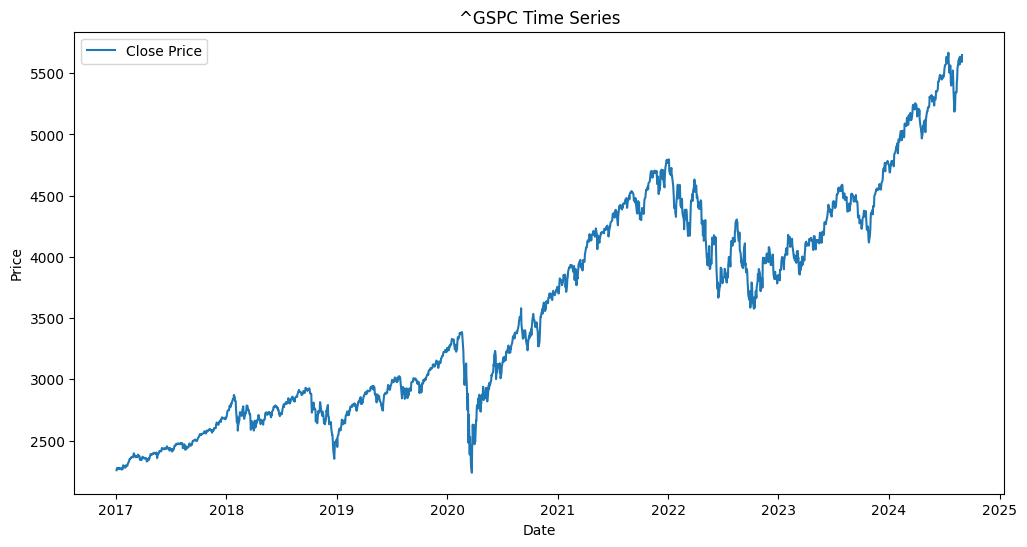

Fitting ARIMA model for ^GSPC...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Best ARIMA order: (2, 1, 2) with AIC: 19665.50213460611


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1928
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -9827.751
Date:                Wed, 25 Sep 2024   AIC                          19665.502
Time:                        01:19:09   BIC                          19693.321
Sample:                             0   HQIC                         19675.736
                               - 1928                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7586      0.025    -71.522      0.000      -1.807      -1.710
ar.L2         -0.8777      0.023    -37.784      0.000      -0.923      -0.832
ma.L1          1.6866      0.031     55.127      0.0

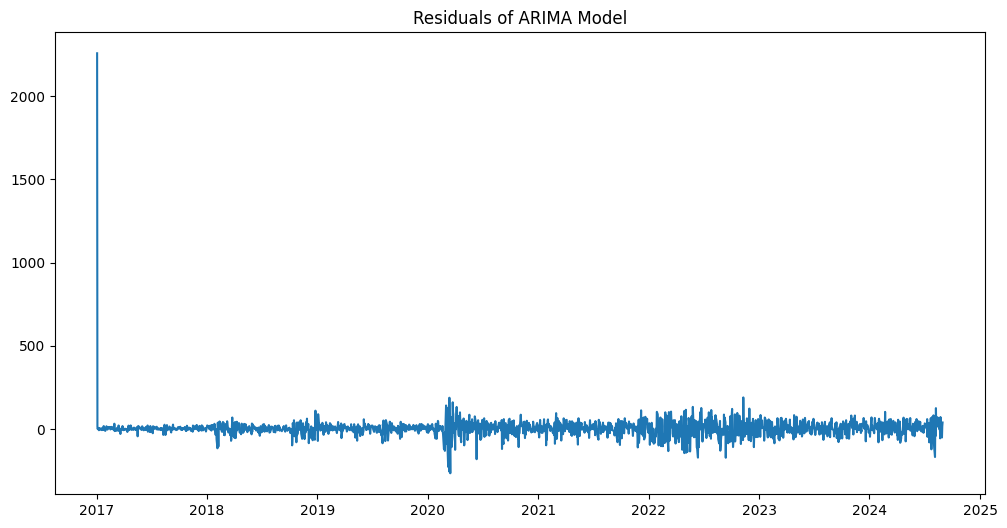

Fitting GARCH model for ^GSPC...
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -15069.5
Distribution:                  Normal   AIC:                           30147.0
Method:            Maximum Likelihood   BIC:                           30169.3
                                        No. Observations:                 1928
Date:                Wed, Sep 25 2024   Df Residuals:                     1927
Time:                        01:19:09   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu          3965.9798    

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 7.827e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


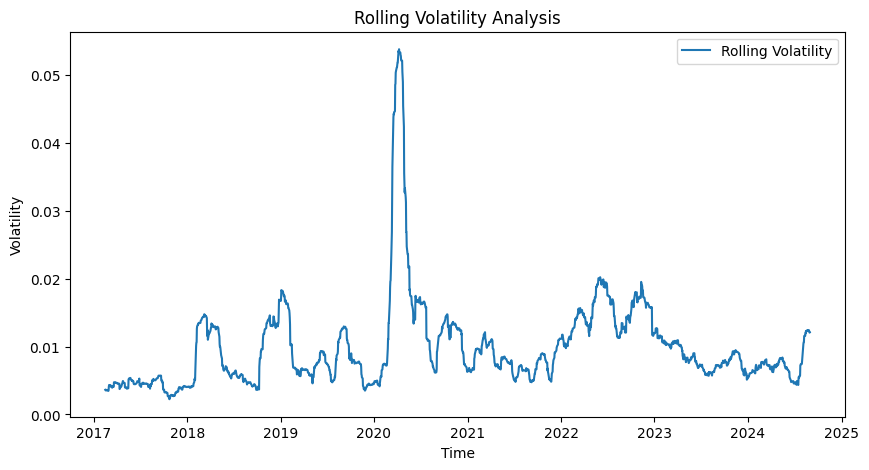

Performing cross-validation on ARIMA model...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

Cross-validation Mean Squared Error (MSE): nan
Performing sensitivity analysis on ARIMA model parameters...
Order (1, 1, 2) - AIC: 19724.067683808906, BIC: 19746.322562482565


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Order (2, 0, 2) - AIC: 19745.872664788, BIC: 19779.258095639023


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Order (2, 1, 1) - AIC: 19724.207951097098, BIC: 19746.462829770757


In [9]:
# Main function to execute the use case
def main():
    # Allow the user to specify which stock index to use
    stock_ticker = input("Enter the ticker symbol of the stock index (e.g., ^GSPC for S&P 500): ").strip()

    # Date range for analysis
    start_date = '2017-01-01'
    end_date = '2024-09-01'

    # Step 1: Fetch market data
    print(f"Fetching data for {stock_ticker} from {start_date} to {end_date}...")
    stock_data = fetch_market_data(start_date, end_date, stock_ticker)

    if stock_data.empty:
        print(f"Failed to fetch data for {stock_ticker}. Please check the ticker symbol or date range.")
        return

    # Step 2: Clean data
    # print(f"Cleaning data for {stock_ticker}...")
    # stock_data = clean_data(stock_data)

    # Step 3: Perform EDA (Exploratory Data Analysis)
    print(f"Performing Exploratory Data Analysis for {stock_ticker}...")
    plot_time_series(stock_data, title=f'{stock_ticker} Time Series')

    # Step 4: Fit ARIMA model and analyze residuals
    print(f"Fitting ARIMA model for {stock_ticker}...")
    arima_order = optimize_arima_params(stock_data)  # Optimize ARIMA order
    arima_model = fit_arima_model(stock_data, order=arima_order)

    print("Analyzing ARIMA model residuals...")
    residuals = analyze_residuals(arima_model)

    # Step 5: Fit GARCH model to the residuals
    print(f"Fitting GARCH model for {stock_ticker}...")
    garch_model = fit_garch_model(stock_data)

    # Step 6: Segment data into pre-pandemic, pandemic, and post-pandemic periods
    pre_pandemic_period = ('2017-01-01', '2019-12-31')
    pandemic_period = ('2020-01-01', '2021-12-31')
    post_pandemic_period = ('2022-01-01', '2024-09-01')

    # Segment the data
    pre_pandemic_data = segment_data_by_period(stock_data, pre_pandemic_period[0], pre_pandemic_period[1])
    pandemic_data = segment_data_by_period(stock_data, pandemic_period[0], pandemic_period[1])
    post_pandemic_data = segment_data_by_period(stock_data, post_pandemic_period[0], post_pandemic_period[1])

    # Step 7: Compare volatility across periods
    print(f"Comparing volatility across pre-pandemic, pandemic, and post-pandemic periods for {stock_ticker}...")
    data_dict = {
        'Pre-Pandemic': pre_pandemic_data,
        'Pandemic': pandemic_data,
        'Post-Pandemic': post_pandemic_data
    }
    compare_volatility_across_periods(data_dict)

    # Step 8: Perform rolling volatility analysis
    print(f"Performing rolling volatility analysis for {stock_ticker}...")
    rolling_volatility_analysis(stock_data)

    # Final Step: Cross-validation and sensitivity analysis
    print("Performing cross-validation on ARIMA model...")
    cross_validate_arima_model(stock_data, arima_order)

    print("Performing sensitivity analysis on ARIMA model parameters...")
    sensitivity_analysis_arima(stock_data, base_order=arima_order)


if __name__ == "__main__":
    main()


In [10]:

# Step 1: Fetch data for a stock index
def fetch_and_clean_data(ticker_symbol, start_date, end_date):
    data = fetch_market_data(start_date, end_date, ticker_symbol)
    if data.empty:
        print(f"Error fetching data for {ticker_symbol}")
        return None
    return clean_data(data)

# Step 2: Perform ARIMA and GARCH analysis on the data
def analyze_market(ticker_symbol, start_date, end_date):
    # Fetch and clean data
    data = fetch_and_clean_data(ticker_symbol, start_date, end_date)
    if data is None:
        return

    # Plot time series for visual inspection
    plot_time_series(data, title=f'{ticker_symbol} Time Series Data')

    # Fit ARIMA model
    print(f"\nFitting ARIMA model for {ticker_symbol}:")
    arima_model = fit_arima_model(data)

    # Fit GARCH model
    print(f"\nFitting GARCH model for {ticker_symbol}:")
    garch_model = fit_garch_model(data)

    return arima_model, garch_model

# Step 3: Compare volatility across periods for US and Asian markets
def compare_markets():
    start_date = '2017-01-01'
    end_date = '2024-09-01'

    # Choose US and Asian markets for comparison
    us_indexes = ['^GSPC', '^RUT']  # S&P 500 and Russell 2000
    asian_indexes = ['^KS11', '^N225']  # KOSPI and Nikkei 225

    # Analyze each index
    for ticker in us_indexes + asian_indexes:
        analyze_market(ticker, start_date, end_date)

# Execute comparison of multiple indexes
compare_markets()


[*********************100%***********************]  1 of 1 completed


KeyError: 'Date'

# Step 1: Fetch and clean data
## 1. Data Collection and Preparation

In [ ]:
# Fetch market data for S&P 500
def fetch_stock_data(start_date, end_date):
    """
    Fetches historical stock data from Yahoo Finance.
    """
    stock_data = yf.download('^GSPC', start=start_date, end=end_date)
    stock_data.reset_index(inplace=True)
    return stock_data



# Data cleaning

In [ ]:
def clean_data(df):
    """
    Cleans the data by handling missing values and standardizing formats.
    """
    df.dropna(inplace=True)  # Remove missing values
    df['Date'] = pd.to_datetime(df['Date'])  # Ensure the date column is in datetime format
    df.set_index('Date', inplace=True)  # Set the date column as index
    return df
# Fetch and clean data
start_date = '2017-01-01'
end_date = '2024-09-01'
stock_data = fetch_stock_data(start_date, end_date)
stock_data_cleaned = clean_data(stock_data)

[*********************100%***********************]  1 of 1 completed


In [ ]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,2251.570068,2263.879883,2245.129883,2257.830078,2257.830078,3773010000
2017-01-04,2261.600098,2272.820068,2261.600098,2270.750000,2270.750000,3768890000
2017-01-05,2268.179932,2271.500000,2260.449951,2269.000000,2269.000000,3785080000
2017-01-06,2271.139893,2282.100098,2264.060059,2276.979980,2276.979980,3342080000
2017-01-09,2273.590088,2275.489990,2268.899902,2268.899902,2268.899902,3219730000
...,...,...,...,...,...,...
2024-08-26,5639.660156,5651.620117,5602.339844,5616.839844,5616.839844,2938570000
2024-08-27,5602.890137,5631.180176,5593.479980,5625.799805,5625.799805,2798990000
2024-08-28,5624.509766,5627.029785,5560.950195,5592.180176,5592.180176,3053450000


In [ ]:
stock_data_cleaned

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,2251.570068,2263.879883,2245.129883,2257.830078,2257.830078,3773010000
2017-01-04,2261.600098,2272.820068,2261.600098,2270.750000,2270.750000,3768890000
2017-01-05,2268.179932,2271.500000,2260.449951,2269.000000,2269.000000,3785080000
2017-01-06,2271.139893,2282.100098,2264.060059,2276.979980,2276.979980,3342080000
2017-01-09,2273.590088,2275.489990,2268.899902,2268.899902,2268.899902,3219730000
...,...,...,...,...,...,...
2024-08-26,5639.660156,5651.620117,5602.339844,5616.839844,5616.839844,2938570000
2024-08-27,5602.890137,5631.180176,5593.479980,5625.799805,5625.799805,2798990000
2024-08-28,5624.509766,5627.029785,5560.950195,5592.180176,5592.180176,3053450000


# Step 2: Perform Exploratory Data Analysis (EDA)

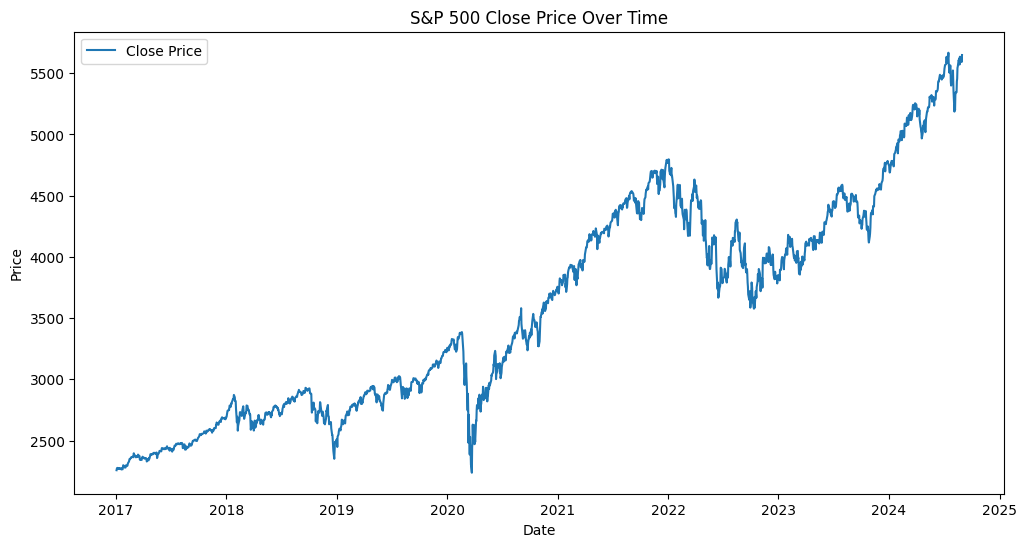

ADF Statistic: -0.11174850526483021
p-value: 0.9482556909017372
Critical Values: 1%, -3.4337657944732745
Critical Values: 5%, -2.863048878223751
Critical Values: 10%, -2.567573268289192


In [ ]:
plot_time_series(stock_data_cleaned, 'S&P 500 Close Price Over Time')
calculate_descriptive_stats(stock_data_cleaned)
stationarity_p_value = test_stationarity(stock_data_cleaned)


# Step 3: Fit ARIMA and GARCH Models

In [ ]:
arima_order = optimize_arima_params(stock_data_cleaned)
arima_model = fit_arima_model(stock_data_cleaned, arima_order)
garch_model = fit_garch_model(stock_data_cleaned)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Best ARIMA order: (2, 1, 2) with AIC: 19665.50213460611


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1928
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -9827.751
Date:                Tue, 17 Sep 2024   AIC                          19665.502
Time:                        15:44:44   BIC                          19693.321
Sample:                             0   HQIC                         19675.736
                               - 1928                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7586      0.025    -71.522      0.000      -1.807      -1.710
ar.L2         -0.8777      0.023    -37.784      0.000      -0.923      -0.832
ma.L1          1.6866      0.031     55.127      0.0

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 7.827e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -15069.5
Distribution:                  Normal   AIC:                           30147.0
Method:            Maximum Likelihood   BIC:                           30169.3
                                        No. Observations:                 1928
Date:                Tue, Sep 17 2024   Df Residuals:                     1927
Time:                        15:44:44   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu          3965.9798      8.229    481.950      0.000 [3.

# Step 4: Perform Cross-Validation on ARIMA model

In [ ]:
arima_order = (1, 1, 1)
cross_validate_arima_model(stock_data_cleaned, arima_order)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

Cross-validation Mean Squared Error (MSE): nan


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


nan

# Step 5: Conduct Sensitivity Analysis

In [ ]:
sensitivity_results = sensitivity_analysis_arima(stock_data_cleaned, base_order=arima_order)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Order (0, 1, 1) - AIC: 19725.042199384705, BIC: 19736.169638721534


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Order (1, 0, 1) - AIC: 19747.739344774745, BIC: 19769.99629867543
Order (1, 1, 0) - AIC: 19723.802767808316, BIC: 19734.930207145146


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


# Step 6: Compare Model Performance

In [ ]:
arima_model = fit_arima_model(stock_data_cleaned, arima_order)
garch_model = fit_garch_model(stock_data_cleaned)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1928
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -9858.488
Date:                Tue, 17 Sep 2024   AIC                          19722.976
Time:                        15:50:48   BIC                          19739.667
Sample:                             0   HQIC                         19729.116
                               - 1928                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3928      0.104     -3.766      0.000      -0.597      -0.188
ma.L1          0.3040      0.109      2.789      0.005       0.090       0.518
sigma2      1628.6017     27.980     58.206      0.0

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 7.827e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


# Step 7: Segment data for comparative analysis
We will segment the data into pre-pandemic, pandemic, and post-pandemic periods and compare volatility

In [ ]:
pre_pandemic_data = segment_data_by_period(stock_data_cleaned, '2017-01-01', '2020-03-01')
pandemic_data = segment_data_by_period(stock_data_cleaned, '2020-03-01', '2021-06-01')
post_pandemic_data = segment_data_by_period(stock_data_cleaned, '2021-06-01', '2024-09-01')


# Step 8: Quantify Volatility Changes
Quantify changes in volatility across periods

Pre-pandemic volatility: 0.008325425089256181
Pandemic volatility: 0.019458319142878364
Post-pandemic volatility: 0.010756389772821942


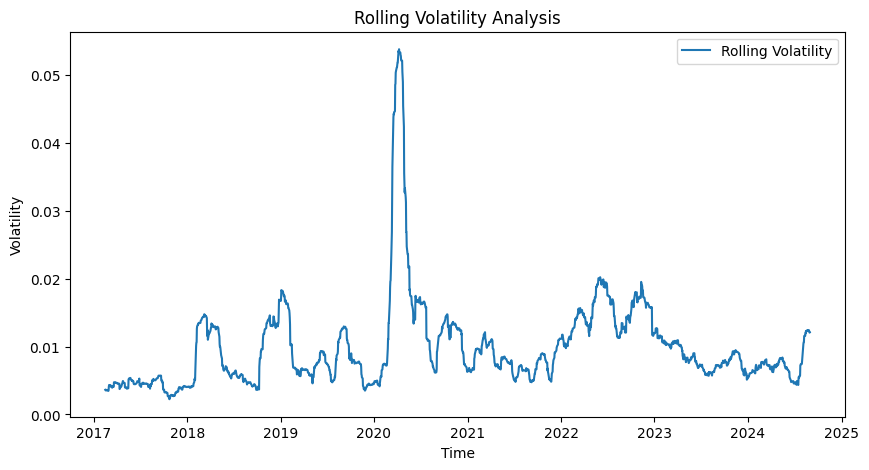

,Close
Date,
2017-01-03,NaN
2017-01-04,NaN
2017-01-05,NaN
2017-01-06,NaN
2017-01-09,NaN
...,...
2024-08-26,0.012415
2024-08-27,0.012361
2024-08-28,0.012139


In [ ]:
calculate_volatility_change(pre_pandemic_data, pandemic_data, post_pandemic_data)
rolling_volatility_analysis(stock_data_cleaned)

# Step 9: Comparative Analysis

In [ ]:
data_periods = {'Pre-Pandemic': pre_pandemic_data, 'Pandemic': pandemic_data, 'Post-Pandemic': post_pandemic_data}
compare_volatility_across_periods(data_periods)
perform_statistical_tests(pre_pandemic_data, pandemic_data)

Volatility comparison across periods: {'Pre-Pandemic': 0.008325425089256181, 'Pandemic': 0.019458319142878364, 'Post-Pandemic': 0.010756389772821942}
T-test results: t-statistic=-0.9496339859436461, p-value=0.3425057202917764


0.3425057202917764

### Generate Insights and Visualize Results

In [ ]:
# summary
summary_stats = generate_summary_statistics(stock_data_cleaned)
summary_stats

Summary Statistics:               Open         High          Low        Close    Adj Close  \
count  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000   
mean   3581.467719  3601.084768  3560.602364  3582.102335  3582.102335   
std     884.552498   889.219281   880.222440   884.943627   884.943627   
min    2251.570068  2263.879883  2191.860107  2237.399902  2237.399902   
25%    2786.604980  2796.269958  2767.567444  2783.967468  2783.967468   
50%    3507.890015  3527.984985  3485.040039  3508.724976  3508.724976   
75%    4308.707397  4337.257324  4275.587402  4305.465088  4305.465088   
max    5644.089844  5669.669922  5639.020020  5667.200195  5667.200195   

             Volume  
count  1.928000e+03  
mean   4.068725e+09  
std    9.964339e+08  
min    1.296530e+09  
25%    3.459325e+09  
50%    3.856720e+09  
75%    4.432690e+09  
max    9.976520e+09  


,Open,High,Low,Close,Adj Close,Volume
count,1928.000000,1928.000000,1928.000000,1928.000000,1928.000000,1.928000e+03
mean,3581.467719,3601.084768,3560.602364,3582.102335,3582.102335,4.068725e+09
std,884.552498,889.219281,880.222440,884.943627,884.943627,9.964339e+08
min,2251.570068,2263.879883,2191.860107,2237.399902,2237.399902,1.296530e+09
25%,2786.604980,2796.269958,2767.567444,2783.967468,2783.967468,3.459325e+09
50%,3507.890015,3527.984985,3485.040039,3508.724976,3508.724976,3.856720e+09
75%,4308.707397,4337.257324,4275.587402,4305.465088,4305.465088,4.432690e+09
max,5644.089844,5669.669922,5639.020020,5667.200195,5667.200195,9.976520e+09


In [ ]:

report = generate_report(stock_data_cleaned, {'ARIMA': arima_model, 'GARCH': garch_model}, insights='COVID-19 significantly increased market volatility.') # also check ARIMA(3, 1, 4)
report


Summary Statistics:               Open         High          Low        Close    Adj Close  \
count  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000   
mean   3581.467719  3601.084768  3560.602364  3582.102335  3582.102335   
std     884.552498   889.219281   880.222440   884.943627   884.943627   
min    2251.570068  2263.879883  2191.860107  2237.399902  2237.399902   
25%    2786.604980  2796.269958  2767.567444  2783.967468  2783.967468   
50%    3507.890015  3527.984985  3485.040039  3508.724976  3508.724976   
75%    4308.707397  4337.257324  4275.587402  4305.465088  4305.465088   
max    5644.089844  5669.669922  5639.020020  5667.200195  5667.200195   

             Volume  
count  1.928000e+03  
mean   4.068725e+09  
std    9.964339e+08  
min    1.296530e+09  
25%    3.459325e+09  
50%    3.856720e+09  
75%    4.432690e+09  
max    9.976520e+09  


{'Data Summary':               Open         High          Low        Close    Adj Close  \
 count  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000   
 mean   3581.467719  3601.084768  3560.602364  3582.102335  3582.102335   
 std     884.552498   889.219281   880.222440   884.943627   884.943627   
 min    2251.570068  2263.879883  2191.860107  2237.399902  2237.399902   
 25%    2786.604980  2796.269958  2767.567444  2783.967468  2783.967468   
 50%    3507.890015  3527.984985  3485.040039  3508.724976  3508.724976   
 75%    4308.707397  4337.257324  4275.587402  4305.465088  4305.465088   
 max    5644.089844  5669.669922  5639.020020  5667.200195  5667.200195   
 
              Volume  
 count  1.928000e+03  
 mean   4.068725e+09  
 std    9.964339e+08  
 min    1.296530e+09  
 25%    3.459325e+09  
 50%    3.856720e+09  
 75%    4.432690e+09  
 max    9.976520e+09  ,
 'Model Insights': {'ARIMA': <class 'statsmodels.iolib.summary.Summary'>
  """
                    

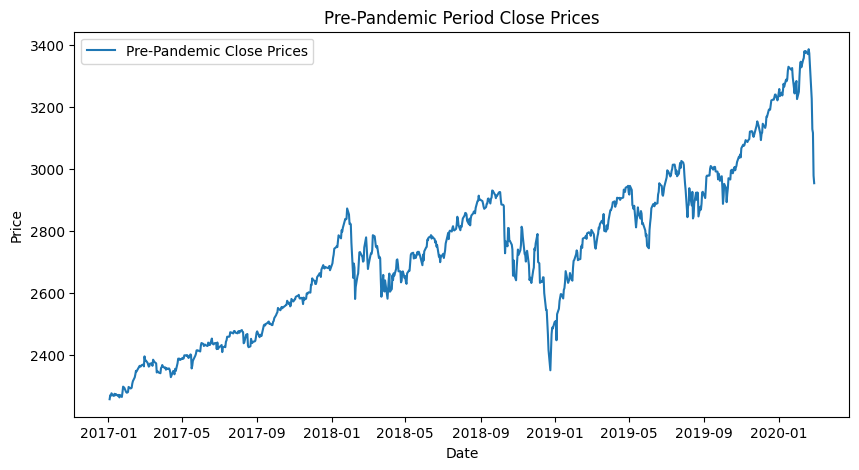

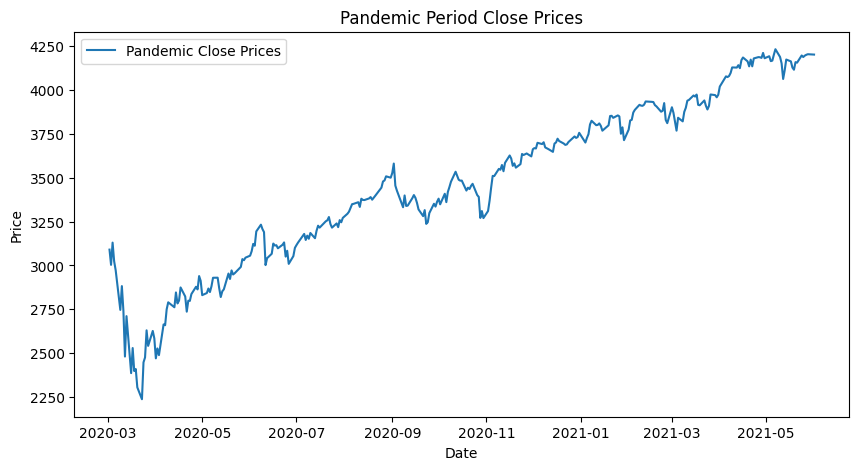

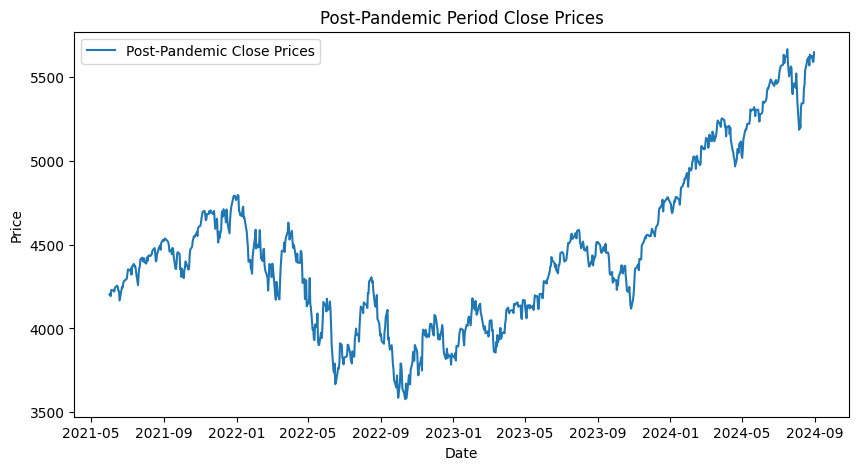

In [ ]:
# Visualize results
visualize_results({'Pre-Pandemic': pre_pandemic_data, 'Pandemic': pandemic_data, 'Post-Pandemic': post_pandemic_data})